
This notebook is focused on hyperspectral image classification using a Long Short-Term Memory (LSTM) deep learning model.

- Data handling: The preprocessed hyperspectral cube and label data are loaded from files. The data is split into training, validation, and test sets using binary masks.

- Reproducibility: Random seeds for both NumPy and PyTorch are set for consistent results across runs. The script automatically selects GPU if available, otherwise defaults to CPU.

- Directory setup: Output directories are defined for storing artifacts, figures, and experiment records, which assists in organizing results.

- Modeling: An LSTM network is employed to process the spectral sequence of each pixel, aiming to classify them according to ground truth labels.

- Evaluation: The notebook uses common machine learning metrics (accuracy, F1-score, Cohen's Kappa) and utilities for model analysis, including options to generate performance plots.

This setup provides a reproducible workflow for sequence-based hyperspectral classification, from data loading and model training to evaluation.




In [1]:
from pathlib import Path                                                   # import from pathlibimport time                                                                # import time libraryimport numpy as np                                                         # import numpy libraryimport matplotlib.pyplot as plt                                            # import matplotlib.pyplot library# empty lineimport torch                                                               # import torch libraryimport torch.nn as nn                                                      # import torch.nn libraryimport torch.optim as optim                                                # import torch.optim libraryfrom torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler  # import from torch.utils.data# empty linefrom sklearn.metrics import (                                              # import from sklearn.metrics    confusion_matrix,    accuracy_score,    precision_recall_fscore_support,    cohen_kappa_score,    classification_report,)# empty linenp.random.seed(42)torch.manual_seed(42)# empty lineARTIFACTS = Path("outputs/artifacts_ip")                                   # define path for ARTIFACTSFIGS = Path("outputs/figs")                                                # define path for FIGSRUNS = Path("outputs/runs_lstm")                                           # define path for RUNSFIGS.mkdir(parents=True, exist_ok=True)                                    # create directory FIGS.mkdir(parentsRUNS.mkdir(parents=True, exist_ok=True)                                    # create directory RUNS.mkdir(parents# empty lineDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")      # set computation device (GPU/CPU)print("Device", DEVICE)

Device cuda


In [2]:
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # H W Blabels = np.load(ARTIFACTS / "labels.npy")                  # H W with 1..C and 0 as backgroundmask_train = np.load(ARTIFACTS / "mask_train.npy")          # assign value to mask_trainmask_val   = np.load(ARTIFACTS / "mask_val.npy")            # assign value to mask_valmask_test  = np.load(ARTIFACTS / "mask_test.npy")           # assign value to mask_test# empty lineH, W, B = cube.shape                                        # assign value to H, W, Bnum_classes = int(labels.max())                             # assign value to num_classesprint("Cube", cube.shape, "Classes", num_classes)

Cube (145, 145, 200) Classes 16


In [3]:
class PixelDatasetSeq(Dataset):                                            # define class PixelDatasetSeq    """Return one spectrum as a sequence and its zero based class id."""    def __init__(self, cube_arr: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray):  # define function __init__        X = cube_arr[mask_map]                                             # N by B        y = lab_map[mask_map]                                              # N        keep = y > 0                                                       # drop background        self.X = X[keep].astype(np.float32)                                # N by B        self.y = (y[keep].astype(np.int64) - 1)                            # zero based    def __len__(self):                                                     # define function __len__        return self.y.shape[0]                                             # return value from function    def __getitem__(self, i):                                              # define function __getitem__        x = torch.from_numpy(self.X[i]).unsqueeze(1)                       # B by 1        y = torch.tensor(self.y[i], dtype=torch.long)                      # assign value to y        return x, y                                                        # return value from function# empty lineds_train = PixelDatasetSeq(cube, labels, mask_train)                       # assign value to ds_trainds_val   = PixelDatasetSeq(cube, labels, mask_val)                         # assign value to ds_valds_test  = PixelDatasetSeq(cube, labels, mask_test)                        # assign value to ds_test# empty lineprint("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test))

Train 7686 Val 513 Test 2050


In [4]:
BATCH = 256                                                                # assign value to BATCH# empty liney_tr = ds_train.y                                                          # assign value to y_trcounts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)       # assign value to countsclass_w = 1.0 / np.maximum(counts, 1.0)                                    # assign value to class_wsample_w = class_w[y_tr]                                                   # assign value to sample_w# empty linesampler = WeightedRandomSampler(                                           # assign value to sampler    weights=torch.from_numpy(sample_w),                                    # assign value to weights    num_samples=len(sample_w),                                             # assign value to num_samples    replacement=True,                                                      # assign value to replacement)# empty linedl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False)  # assign value to dl_traindl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False)  # assign value to dl_valdl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False)  # assign value to dl_test# empty lineprint("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))

Batches  train 31 val 3 test 9


In [5]:
class SpectralLSTM_Attn(nn.Module):                                        # define class SpectralLSTM_Attn    """    Input is batch by B by 1    LSTM encodes along bands    Attention pools across time steps    """    def __init__(self, input_size: int, hidden: int, layers: int, num_classes: int, p_drop: float = 0.3, bidir: bool = True, mean_pool: bool = False):  # assign value to def __init__(self, input_size: int, hidden: int, layers: int, num_classes: int, p_drop: float        super().__init__()        self.mean_pool = mean_pool                                         # assign value to self.mean_pool        self.lstm = nn.LSTM(                                               # assign value to self.lstm            input_size=input_size,                                         # assign value to input_size            hidden_size=hidden,                                            # assign value to hidden_size            num_layers=layers,                                             # assign value to num_layers            batch_first=True,                                              # assign value to batch_first            bidirectional=bidir,                                           # assign value to bidirectional            dropout=p_drop if layers > 1 else 0.0,                         # assign value to dropout        )        d = hidden * (2 if bidir else 1)                                   # assign value to d        self.attn = nn.Sequential(                                         # assign value to self.attn            nn.Linear(d, d),            nn.Tanh(),            nn.Linear(d, 1),        )        self.head = nn.Sequential(                                         # assign value to self.head            nn.Dropout(p_drop),            nn.Linear(d, 256),            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.Dropout(p_drop),            nn.Linear(256, num_classes),        )# empty line    def forward(self, x):                                                  # x shape batch by B by 1        seq, _ = self.lstm(x)                                              # batch by B by d        if self.mean_pool:                                                 # conditional statement            z = seq.mean(dim=1)                                            # simple mean        else:                                                              # conditional statement            w = self.attn(seq).squeeze(-1)                                 # batch by B            w = torch.softmax(w, dim=1)                                    # weights over bands            z = (seq * w.unsqueeze(-1)).sum(1)                             # assign value to z        return self.head(z)                                                # return value from function# empty lineHIDDEN = 256                                                               # assign value to HIDDENLAYERS = 2                                                                 # assign value to LAYERSP_DROP = 0.3                                                               # assign value to P_DROPBIDIR = True                                                               # assign value to BIDIRMEAN_POOL = False                                                          # assign value to MEAN_POOL# empty linemodel = SpectralLSTM_Attn(input_size=1, hidden=HIDDEN, layers=LAYERS, num_classes=num_classes, p_drop=P_DROP, bidir=BIDIR, mean_pool=MEAN_POOL).to(DEVICE)  # assign value to modelprint("Params", sum(p.numel() for p in model.parameters()))

Params 2506001


In [6]:
criterion = nn.CrossEntropyLoss()                                          # assign value to criterionoptimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)    # assign value to optimizerscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)      # assign value to scheduler# empty linedef metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # define function metrics_from_logits    preds = logits.argmax(1).cpu().numpy()                                 # assign value to preds    true = targets.cpu().numpy()                                           # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    cm = confusion_matrix(true, preds, labels=np.arange(C))                # assign value to cm    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}  # return value from function

In [7]:
EPOCHS = 120                                                               # assign value to EPOCHSPATIENCE = 15                                                              # assign value to PATIENCEbest_score = float("-inf")                                                 # assign value to best_scorebest_state = None                                                          # assign value to best_statebest_epoch = 0                                                             # assign value to best_epochbad_epochs = 0                                                             # assign value to bad_epochshistory = []                                                               # assign value to history# empty linet0 = time.time()                                                           # assign value to t0# empty linefor ep in range(1, EPOCHS + 1):                                            # loop iteration                                                                           # train    model.train()    run = 0.0                                                              # assign value to run    n = 0                                                                  # assign value to n    for xb, yb in dl_train:                                                # loop iteration        xb = xb.to(DEVICE)                                                 # batch by B by 1        yb = yb.to(DEVICE)                                                 # assign value to yb        optimizer.zero_grad(set_to_none=True)                              # assign value to optimizer.zero_grad(set_to_none        lg = model(xb)                                                     # assign value to lg        ls = criterion(lg, yb)                                             # assign value to ls        ls.backward()        optimizer.step()        run += ls.item() * xb.size(0)                                      # assign value to run +        n += xb.size(0)                                                    # assign value to n +    tr_loss = run / max(1, n)                                              # assign value to tr_loss# empty line                                                                           # val    model.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_val:                                              # loop iteration            lg = model(xb.to(DEVICE))                                      # assign value to lg            all_lg.append(lg)            all_y.append(yb.to(DEVICE))        lg_cat = torch.cat(all_lg, 0)                                      # assign value to lg_cat        y_cat  = torch.cat(all_y, 0)                                       # assign value to y_cat        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)        # assign value to v_metrics    scheduler.step()# empty line    history.append({"epoch": ep, "train_loss": tr_loss, "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")# empty line    if v_metrics["f1"] > best_score:                                       # conditional statement        best_score = v_metrics["f1"]                                       # assign value to best_score        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}  # assign value to best_state        best_epoch = ep                                                    # assign value to best_epoch        bad_epochs = 0                                                     # assign value to bad_epochs    else:                                                                  # conditional statement        bad_epochs += 1                                                    # assign value to bad_epochs +        if bad_epochs >= PATIENCE:                                         # assign value to if bad_epochs >            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))            break# empty linetrain_time = time.time() - t0                                              # assign value to train_timeprint("Train time seconds", round(train_time, 2))# empty lineckpt_path = RUNS / "lstm_attn_best.pth"                                    # assign value to ckpt_pathtorch.save({"state_dict": best_state, "num_classes": num_classes, "B": B}, ckpt_path)print("Saved", ckpt_path.as_posix())

Epoch 001  tl 2.4137  va 0.0799  vf 0.0316
Epoch 002  tl 1.8529  va 0.2671  vf 0.1682
Epoch 003  tl 1.6869  va 0.1969  vf 0.1620
Epoch 004  tl 1.6107  va 0.2729  vf 0.1942
Epoch 005  tl 1.4989  va 0.2222  vf 0.1858
Epoch 006  tl 1.4813  va 0.2904  vf 0.2423
Epoch 007  tl 1.3737  va 0.3450  vf 0.2660
Epoch 008  tl 1.3637  va 0.2554  vf 0.2839
Epoch 009  tl 1.7545  va 0.2476  vf 0.1901
Epoch 010  tl 1.4843  va 0.3060  vf 0.2763
Epoch 011  tl 1.3720  va 0.4035  vf 0.3393
Epoch 012  tl 1.3450  va 0.3353  vf 0.3583
Epoch 013  tl 1.2967  va 0.4191  vf 0.3263
Epoch 014  tl 1.2439  va 0.3197  vf 0.3659
Epoch 015  tl 1.1540  va 0.4211  vf 0.3829
Epoch 016  tl 1.1113  va 0.4483  vf 0.4810
Epoch 017  tl 1.0819  va 0.4581  vf 0.4259
Epoch 018  tl 1.0557  va 0.4912  vf 0.4802
Epoch 019  tl 0.9874  va 0.4717  vf 0.4855
Epoch 020  tl 0.9629  va 0.5244  vf 0.5106
Epoch 021  tl 0.9726  va 0.4464  vf 0.4177
Epoch 022  tl 1.0174  va 0.5322  vf 0.5285
Epoch 023  tl 0.9120  va 0.5556  vf 0.5470
Epoch 024  

Val accuracy 0.6159844054580896
Val kappa 0.5679399756311323
Val f1 macro 0.6839635039930498


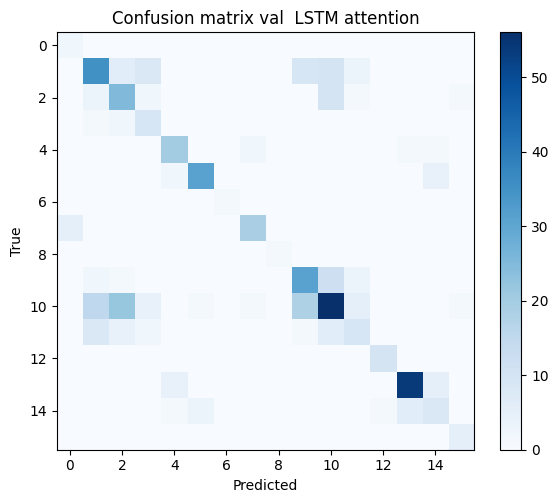

In [8]:
model.load_state_dict(best_state)model.to(DEVICE).eval()# empty linewith torch.no_grad():    v_logits, v_targets = [], []                                # assign value to v_logits, v_targets    for xb, yb in dl_val:                                       # loop iteration        v_logits.append(model(xb.to(DEVICE)))        v_targets.append(yb.to(DEVICE))    v_logits = torch.cat(v_logits, 0)                           # assign value to v_logits    v_targets = torch.cat(v_targets, 0)                         # assign value to v_targets    vm = metrics_from_logits(v_logits, v_targets, num_classes)  # assign value to vm# empty lineprint("Val accuracy", vm["acc"])print("Val kappa", vm["kappa"])print("Val f1 macro", vm["f1"])# empty lineplt.figure(figsize=(6, 5))                                      # assign value to plt.figure(figsizeplt.imshow(vm["cm"], cmap="Blues")                              # assign value to plt.imshow(vm["cm"], cmapplt.title("Confusion matrix val  LSTM attention")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "lstm_attn_confusion_val.png", dpi=150)      # assign value to plt.savefig(FIGS / "lstm_attn_confusion_val.png", dpiplt.show()

Test accuracy 0.5629268292682926
Test kappa 0.5092348440054537
Test f1 macro 0.5999787340896469


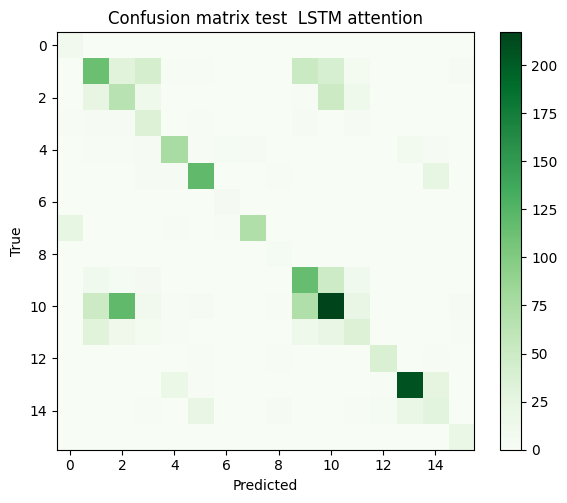


Classification report on test
              precision    recall  f1-score   support

     class_1     0.2727    1.0000    0.4286         9
     class_2     0.4871    0.3951    0.4363       286
     class_3     0.2790    0.3916    0.3258       166
     class_4     0.3043    0.7447    0.4321        47
     class_5     0.7600    0.7835    0.7716        97
     class_6     0.8082    0.8082    0.8082       146
     class_7     0.5000    1.0000    0.6667         5
     class_8     0.9726    0.7396    0.8402        96
     class_9     0.4000    1.0000    0.5714         4
    class_10     0.4585    0.5979    0.5190       194
    class_11     0.5787    0.4420    0.5012       491
    class_12     0.3864    0.2857    0.3285       119
    class_13     0.8837    0.9268    0.9048        41
    class_14     0.8879    0.8142    0.8495       253
    class_15     0.3415    0.3636    0.3522        77
    class_16     0.7600    1.0000    0.8636        19

    accuracy                         0.5629      

In [9]:
with torch.no_grad():    t_logits, t_targets = [], []                                           # assign value to t_logits, t_targets    for xb, yb in dl_test:                                                 # loop iteration        t_logits.append(model(xb.to(DEVICE)))        t_targets.append(yb.to(DEVICE))    t_logits = torch.cat(t_logits, 0)                                      # assign value to t_logits    t_targets = torch.cat(t_targets, 0)                                    # assign value to t_targets    tm = metrics_from_logits(t_logits, t_targets, num_classes)             # assign value to tm# empty lineprint("Test accuracy", tm["acc"])print("Test kappa", tm["kappa"])print("Test f1 macro", tm["f1"])# empty lineplt.figure(figsize=(6, 5))                                                 # assign value to plt.figure(figsizeplt.imshow(tm["cm"], cmap="Greens")                                        # assign value to plt.imshow(tm["cm"], cmapplt.title("Confusion matrix test  LSTM attention")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "lstm_attn_confusion_test.png", dpi=150)                # assign value to plt.savefig(FIGS / "lstm_attn_confusion_test.png", dpiplt.show()# empty linenames = [f"class_{i}" for i in range(1, num_classes + 1)]                  # assign value to namesprint("\nClassification report on test")print(classification_report(t_targets.cpu().numpy(), t_logits.argmax(1).cpu().numpy(), target_names=names, digits=4, zero_division=0))  # print output message

In [10]:
from sklearn.metrics import (                                              # import from sklearn.metrics    accuracy_score,    cohen_kappa_score,    precision_recall_fscore_support,    classification_report,    confusion_matrix,)# empty line                                                                           # convert tensors to numpyy_true = t_targets.cpu().numpy()                                           # assign value to y_truey_pred = t_logits.argmax(1).cpu().numpy()                                  # assign value to y_pred# empty line                                                                           # global metricsoa = accuracy_score(y_true, y_pred)                                        # assign value to oakappa = cohen_kappa_score(y_true, y_pred)                                  # assign value to kappa# empty lineprec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(      # assign value to prec_macro, rec_macro, f1_macro, _    y_true, y_pred, average="macro", zero_division=0                       # assign value to y_true, y_pred, average)prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(  # assign value to prec_weighted, rec_weighted, f1_weighted, _    y_true, y_pred, average="weighted", zero_division=0                    # assign value to y_true, y_pred, average)# empty line                                                                           # per class metricsprec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(  # assign value to prec_class, rec_class, f1_class, support_class    y_true, y_pred, average=None, zero_division=0                          # assign value to y_true, y_pred, average)# empty lineprint("Overall accuracy:", oa)print("Cohen kappa:", kappa)print("Macro precision:", prec_macro)print("Macro recall:", rec_macro)print("Macro f1:", f1_macro)print("Weighted precision:", prec_weighted)print("Weighted recall:", rec_weighted)print("Weighted f1:", f1_weighted)# empty lineprint("\nPer class metrics")for i, (p, r, f1, s) in enumerate(                                         # loop iteration    zip(prec_class, rec_class, f1_class, support_class), start=1           # assign value to zip(prec_class, rec_class, f1_class, support_class), start):    print(        f"Class {i:02d}: "        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"     # assign value to f"precision    )# empty lineprint("\nFull classification report")print(    classification_report(        y_true,        y_pred,        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],    # assign value to target_names        digits=4,                                                          # assign value to digits        zero_division=0,                                                   # assign value to zero_division    ))

Overall accuracy: 0.5629268292682926
Cohen kappa: 0.5092348440054537
Macro precision: 0.567536227832276
Macro recall: 0.7058101363594651
Macro f1: 0.5999787340896469
Weighted precision: 0.5913280530535108
Weighted recall: 0.5629268292682926
Weighted f1: 0.5675836796618149

Per class metrics
Class 01: precision=0.2727, recall=1.0000, f1=0.4286, support=9
Class 02: precision=0.4871, recall=0.3951, f1=0.4363, support=286
Class 03: precision=0.2790, recall=0.3916, f1=0.3258, support=166
Class 04: precision=0.3043, recall=0.7447, f1=0.4321, support=47
Class 05: precision=0.7600, recall=0.7835, f1=0.7716, support=97
Class 06: precision=0.8082, recall=0.8082, f1=0.8082, support=146
Class 07: precision=0.5000, recall=1.0000, f1=0.6667, support=5
Class 08: precision=0.9726, recall=0.7396, f1=0.8402, support=96
Class 09: precision=0.4000, recall=1.0000, f1=0.5714, support=4
Class 10: precision=0.4585, recall=0.5979, f1=0.5190, support=194
Class 11: precision=0.5787, recall=0.4420, f1=0.5012, sup

In [11]:
X_tv = np.concatenate([ds_train.X, ds_val.X], axis=0).astype(np.float32)  # assign value to X_tvy_tv = np.concatenate([ds_train.y, ds_val.y], axis=0).astype(np.int64)    # assign value to y_tvC_tv = int(y_tv.max()) + 1                                                # assign value to C_tvprint("TV set", X_tv.shape, "labels", y_tv.shape, "classes", C_tv)assert y_tv.min() >= 0 and y_tv.max() < C_tv                              # assign value to assert y_tv.min() >

TV set (8199, 200) labels (8199,) classes 16


In [12]:
from sklearn.model_selection import StratifiedKFold                        # import from sklearn.model_selection# empty lineCV_DEVICE = torch.device("cpu")                                            # set computation device (GPU/CPU)torch.backends.cudnn.enabled = False                                       # assign value to torch.backends.cudnn.enabled# empty lineclass LSTMFold(nn.Module):                                                 # define class LSTMFold    def __init__(self, input_size, hidden, layers, C, p_drop=0.3, bidir=True, mean_pool=False):  # assign value to def __init__(self, input_size, hidden, layers, C, p_drop        super().__init__()        self.mean_pool = mean_pool                                         # assign value to self.mean_pool        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden, num_layers=layers,  # assign value to self.lstm                            batch_first=True, bidirectional=bidir, dropout=p_drop if layers > 1 else 0.0)  # assign value to batch_first        d = hidden * (2 if bidir else 1)                                   # assign value to d        self.attn = nn.Sequential(nn.Linear(d, d), nn.Tanh(), nn.Linear(d, 1))  # assign value to self.attn        self.head = nn.Sequential(nn.Dropout(p_drop), nn.Linear(d, 256), nn.ReLU(inplace=True),  # assign value to self.head                                  nn.Dropout(p_drop), nn.Linear(256, C))    def forward(self, x):                                                  # define function forward        seq, _ = self.lstm(x)                                              # assign value to seq, _        if self.mean_pool:                                                 # conditional statement            z = seq.mean(1)                                                # assign value to z        else:                                                              # conditional statement            w = torch.softmax(self.attn(seq).squeeze(-1), dim=1)           # assign value to w            z = (seq * w.unsqueeze(-1)).sum(1)                             # assign value to z        return self.head(z)                                                # return value from function# empty linedef train_one_fold_lstm_cpu(X_tr, y_tr, X_va, y_va, hidden=256, layers=2, p_drop=0.3, bidir=True, mean_pool=False, epochs=80, patience=10):  # assign value to def train_one_fold_lstm_cpu(X_tr, y_tr, X_va, y_va, hidden    model_f = LSTMFold(1, hidden, layers, C_tv, p_drop, bidir, mean_pool).to(CV_DEVICE)  # assign value to model_f    crit = nn.CrossEntropyLoss()                                           # assign value to crit    opt = optim.AdamW(model_f.parameters(), lr=1e-3, weight_decay=5e-5)    # assign value to opt    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=40)              # assign value to sch# empty line    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr).unsqueeze(2), torch.from_numpy(y_tr)), batch_size=256, shuffle=True)  # assign value to dl_tr    dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va).unsqueeze(2), torch.from_numpy(y_va)), batch_size=256, shuffle=False)  # assign value to dl_va# empty line    best, best_state, bad = -1.0, None, 0                                  # assign value to best, best_state, bad    for ep in range(1, epochs + 1):                                        # loop iteration        model_f.train()        for xb, yb in dl_tr:                                               # loop iteration            opt.zero_grad(set_to_none=True)                                # assign value to opt.zero_grad(set_to_none            lg = model_f(xb.to(CV_DEVICE))                                 # assign value to lg            ls = crit(lg, yb.to(CV_DEVICE))                                # assign value to ls            ls.backward()            opt.step()        sch.step()# empty line        model_f.eval()        with torch.no_grad():            all_lg, all_y = [], []                                         # assign value to all_lg, all_y            for xb, yb in dl_va:                                           # loop iteration                all_lg.append(model_f(xb.to(CV_DEVICE)))                all_y.append(yb.to(CV_DEVICE))            lg = torch.cat(all_lg, 0)                                      # assign value to lg            tg = torch.cat(all_y, 0)                                       # assign value to tg            preds = lg.argmax(1).cpu().numpy()                             # assign value to preds            true = tg.cpu().numpy()                                        # assign value to true            f1 = precision_recall_fscore_support(true, preds, labels=np.arange(C_tv), average="macro", zero_division=0)[2]  # assign value to f1        if f1 > best:                                                      # conditional statement            best = f1                                                      # assign value to best            best_state = {k: v.cpu().clone() for k, v in model_f.state_dict().items()}  # assign value to best_state            bad = 0                                                        # assign value to bad        else:                                                              # conditional statement            bad += 1                                                       # assign value to bad +            if bad >= patience:                                            # assign value to if bad >                break# empty line    model_f.load_state_dict(best_state)    model_f.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_va:                                               # loop iteration            all_lg.append(model_f(xb.to(CV_DEVICE)))            all_y.append(yb.to(CV_DEVICE))        lg = torch.cat(all_lg, 0)                                          # assign value to lg        tg = torch.cat(all_y, 0)                                           # assign value to tg    preds = lg.argmax(1).cpu().numpy()                                     # assign value to preds    true = tg.cpu().numpy()                                                # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C_tv), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    return acc, f1, kap                                                    # return value from function# empty lineskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)           # assign value to skfaccs, f1s, kaps = [], [], []                                               # assign value to accs, f1s, kapsfor fold, (i_tr, i_va) in enumerate(skf.split(X_tv, y_tv), 1):             # loop iteration    X_tr, y_tr = X_tv[i_tr], y_tv[i_tr]                                    # assign value to X_tr, y_tr    X_va, y_va = X_tv[i_va], y_tv[i_va]                                    # assign value to X_va, y_va    acc, f1, kap = train_one_fold_lstm_cpu(X_tr, y_tr, X_va, y_va, hidden=256, layers=2, p_drop=0.3, bidir=True, mean_pool=False)  # assign value to acc, f1, kap    print(f"Fold {fold}  acc {acc:.4f}  f1 {f1:.4f}  kappa {kap:.4f}")    accs.append(acc); f1s.append(f1); kaps.append(kap)# empty lineprint("\nCV mean acc", np.mean(accs).round(4), "std", np.std(accs).round(4))print("CV mean f1", np.mean(f1s).round(4), "std", np.std(f1s).round(4))print("CV mean kappa", np.mean(kaps).round(4), "std", np.std(kaps).round(4))

KeyboardInterrupt: 